In [1]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import sys
import numpy as np
import ipywidgets as widgets
from ipywidgets import Box, IntSlider
import seaborn as sns

In [2]:
sys.path.append('../scms_py')
from scMSData import scMSData
from analysis import scMSAnalysis
from model import scMSModel


          SPIKE
    Version     : 0.99.30
    Date        : 22-03-2022
    Revision Id : 563
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 


In [3]:
scms = scMSData()
path = 'ICC_use/xmls/'
file_paths = scms.getXMLPath(path)
scms.loadXMLData_tof(detailed=True)

100%|█████████████████████████████████████| 1522/1522 [00:00<00:00, 1706.82it/s]


In [14]:
scms_icr = scMSData()
path = '20210825_AstroNeuron_and_Unfixed/Stained'
file_paths = scms_icr.getXMLPath(path)
scms_icr.loadXMLData(detailed=True)

100%|███████████████████████████████████████| 2398/2398 [01:23<00:00, 28.57it/s]


In [64]:
pk_count_icr = []
snr_icr = []
res_icr = []
mz_icr = []
for idx in list(scms_icr.peak_list.keys())[:500]:
    snr = scms_icr.peak_list[idx]['snr']
    pk_count_icr.append(scms_icr.peak_list[idx]['intensity'][snr>5].shape[0])
    mz_icr+=list(scms_icr.peak_list[idx]['mzs'][snr>5])
    snr_icr+=list(scms_icr.peak_list[idx]['snr'][snr>5])
    res_icr+=list(scms_icr.peak_list[idx]['res'][snr>5])

In [76]:
np.array(mz_icr)[(np.array(mz_icr)>500)&(np.array(mz_icr)<1000)]

array([500.037503, 500.323055, 501.045583, ..., 990.76174 , 991.758979,
       994.738178])

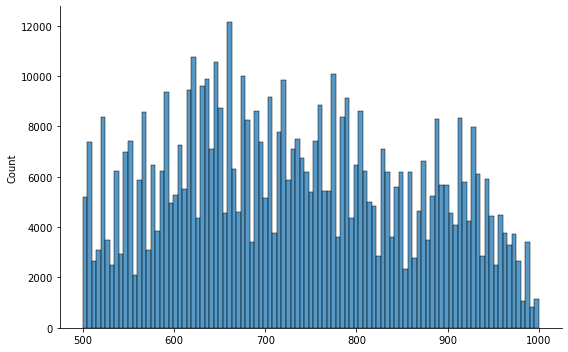

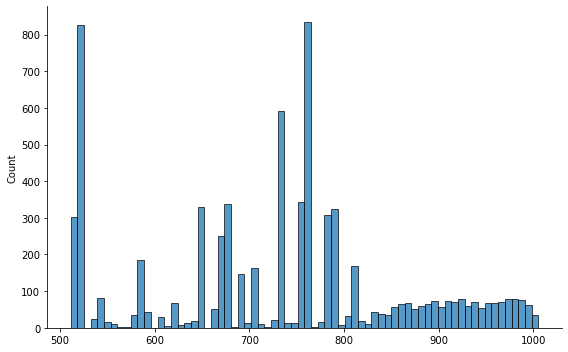

In [114]:
sns.displot(np.array(mz_icr)[(np.array(mz_icr)>500)&(np.array(mz_icr)<1000)],aspect=1.6)
plt.savefig('figures/icr_hist.pdf')
sns.displot(mz_tof,bins=70,aspect=1.6)
plt.savefig('figures/tof_hist.pdf')

In [68]:
pk_count_tof = []
snr_tof = []
res_tof = []
mz_tof = []
for idx in df[df['type']=='Neurons'].index[:500]:
    if idx in scms.peak_list.keys():
        snr = scms.peak_list[idx]['snr']
        pk_count_tof.append(scms.peak_list[idx]['intensity'][snr>5].shape[0])
        mz_tof+=list(scms.peak_list[idx]['mzs'][snr>5])
        snr_tof+=list(scms.peak_list[idx]['snr'][snr>5])
        res_tof+=list(scms.peak_list[idx]['res'][snr>5])

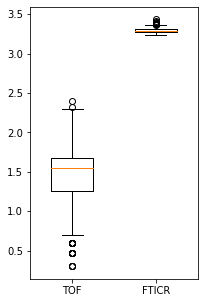

In [115]:
plt.figure(figsize=(3,5))
plt.boxplot([np.log10(pk_count),np.log10(pk_count_icr)],labels=['TOF','FTICR'],widths=0.5)
plt.savefig('figures/pk_count.pdf')

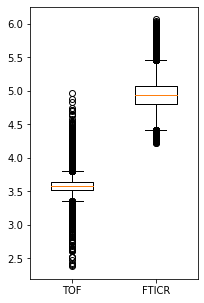

In [116]:
plt.figure(figsize=(3,5))
plt.boxplot([np.log10(res_tof),np.log10(res_icr)],labels=['TOF','FTICR'],widths=0.5)
plt.savefig('figures/res_count.pdf')

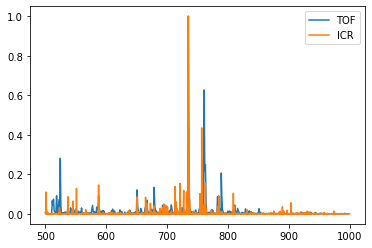

In [103]:
plt.plot(df.drop('type',axis=1).columns,df.drop('type',axis=1).mean(0)/df.drop('type',axis=1).mean(0).max(),label='TOF')
plt.plot(scms_icr.intens_mtx.columns,scms_icr.intens_mtx.mean(0)/scms_icr.intens_mtx.mean(0).max(),label='ICR')
plt.legend()
plt.savefig('figures/tof_icr_spectra.pdf')

In [91]:
scms_icr.loadimzMLData('20210825_AstroNeuron_and_Unfixed/Stained.imzML')
scms_icr.getIntensMtxData(ppm=5, feature_n=0.1, mz_range=(500,1000))

TODO: convert indices into real world coordinates
loaded spectra
file loaded
number of mass bins 69317


100%|██████████████████████████████████| 69317/69317 [00:03<00:00, 19136.41it/s]


In [9]:
df = pd.read_pickle('ICC_use/ICC_rms.pkl')

<AxesSubplot:xlabel='type', ylabel='count'>

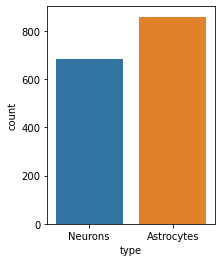

In [5]:
plt.figure(figsize=(3,4))
sns.countplot(x = 'type', data=df)

In [8]:
scmodel = scMSModel(data,metadata)
scmodel.get_labels(['type'])

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [3]:
scmodel = scMSModel(data,metadata)

nn_kwargs = {'layer_shapes':[128,64,1]}
scmodel.train_models(k=5, cv=True, shap=True,
                     model_names=['LR','LDA','SVM','GBT','RF','DNN'],
                     label_name='type',kwargs=nn_kwargs)

In [ ]:
scmodel.feature_selection(n_eliminate=10, model_name='DNN',
                          kwargs=train_params, max_feat=310,
                          min_feat=10)

In [ ]:
f1 = []
model_names = []
for key in scmodel.test_metrics.keys():
    f1+=[metric['f1'] for metric in scmodel.test_metrics[key]]
    model_names+=[key for metric in scmodel.test_metrics[key]]
cv_df = pd.DataFrame({'f1':f1,'model':model_names})

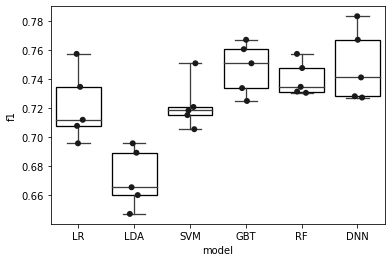

In [ ]:
plt.figure()
ax = sns.boxplot(x='model',y='f1',data=cv_df,fliersize=0, whis = 100, linewidth=1.3)
sns.stripplot(x='model',y='f1',data=cv_df,
              size=6, color=".3", linewidth=0)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
plt.show()

In [11]:
train_params={'k':5, 'cv':True, 'shap':True, 'model_names':['DNN'], 'label_name':'type',
              'kwargs':nn_kwargs}
scmodel.feature_selection(n_eliminate=10, model_name='DNN',
                          kwargs=train_params, max_feat=310,
                          min_feat=10)

performing 5 fold cross validation for DNN
cross validation 0...
cross validation 1...
cross validation 2...
cross validation 3...
cross validation 4...
now testing 300 features..
performing 5 fold cross validation for DNN
cross validation 0...
cross validation 1...
cross validation 2...
cross validation 3...
cross validation 4...
now testing 290 features..
performing 5 fold cross validation for DNN
cross validation 0...
cross validation 1...
cross validation 2...
cross validation 3...
cross validation 4...
now testing 280 features..
performing 5 fold cross validation for DNN
cross validation 0...
cross validation 1...
cross validation 2...
cross validation 3...
cross validation 4...
now testing 270 features..
performing 5 fold cross validation for DNN
cross validation 0...
cross validation 1...
cross validation 2...
cross validation 3...
cross validation 4...
now testing 260 features..
performing 5 fold cross validation for DNN
cross validation 0...
cross validation 1...
cross validat

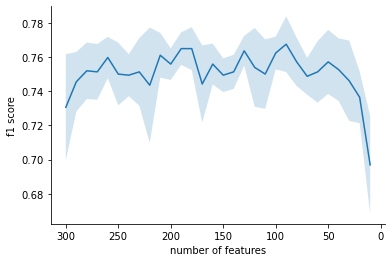

In [12]:
mean_f1 = []
std_f1 = []
for i in range(len(scmodel.feature_retain_metric)-1):
    mean_f1.append(np.mean([metric['f1'] for metric in scmodel.feature_retain_metric[i+1]['DNN']]))
    std_f1.append(np.std([metric['f1'] for metric in scmodel.feature_retain_metric[i+1]['DNN']]))
    
num_feat = [len(feat) for feat in scmodel.feature_retain[1:]]
mean_f1 = np.array(mean_f1)
std_f1 = np.array(std_f1)

fig,axes = plt.subplots(1,1,figsize=(6,4))
#std = np.array([np.std(snr) for snr in SNR])
plt.plot(num_feat,mean_f1)
plt.fill_between(num_feat, mean_f1-std_f1, mean_f1+std_f1,alpha=0.2)
plt.xlabel('number of features')
plt.ylabel('f1 score')
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.gca().invert_xaxis()

In [13]:
fig.savefig('figures/feat_select_icc.pdf')

In [8]:
from sklearn.model_selection import train_test_split
train_names = list(set(scmodel.names) - set(scmodel.cv_test[0]))
X_train = scmodel.intens_mtx.loc[train_names].values
X_test = scmodel.intens_mtx.loc[scmodel.cv_test[0]].values
y_train = scmodel.metadata.loc[train_names]['type_int'].values
y_test = scmodel.metadata.loc[scmodel.cv_test[0]]['type_int'].values

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, f1_score
from sklearn.utils import shuffle

In [67]:
p,pred = scmodel.predict_DNN(X_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, p)

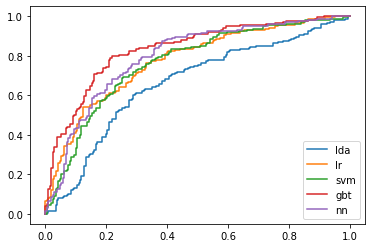

In [68]:
plt.figure()
plt.plot(fpr_lda,tpr_lda,label='lda')
plt.plot(fpr_lr,tpr_lr,label='lr')
plt.plot(fpr_svm,tpr_svm,label='svm')
plt.plot(fpr_gbt,tpr_gbt,label='gbt')
plt.plot(fpr_nn,tpr_nn,label='nn')

plt.legend()
plt.show()

In [21]:
shap_vals = scmodel.get_shap_vals(X_train,X_test,'RF')

 98%|===================| 757/772 [00:26<00:00]        

In [21]:
scmodel.intens_mtx[scmodel.metadata['type']=='Neurons']

,510.28,511.32,512.29,513.32,514.32,515.32,517.29,518.35,519.30,520.29,...,987.62,988.63,989.68,990.60,991.74,992.72,993.59,994.54,995.53,997.63
x_10412y_16754,0.0,0.514763,0.360081,0.697731,0.174104,0.000000,0.000000,1.562168,0.255871,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
x_11953y_16755,0.0,1.216098,0.962318,1.209912,0.282644,0.238123,0.000000,1.277035,0.336079,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
x_12154y_17714,0.0,0.646368,0.481581,1.278379,0.327409,0.187171,0.000000,3.152753,0.646713,0.125125,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
x_12360y_17254,0.0,1.180529,0.652149,2.189925,0.467382,0.200060,0.128717,2.244439,0.500761,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
x_14022y_18082,0.0,3.058327,2.101446,5.624392,1.406737,1.047677,0.499547,2.825733,1.300733,0.483882,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x_6815y_21607,0.0,0.070316,0.047850,0.097639,0.000000,0.000000,0.000000,0.825917,0.088494,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.046268,0.0,0.0,0.0,0.000000
x_9386y_21806,0.0,0.376629,0.261349,0.210994,0.133808,0.000000,0.000000,1.378805,0.154349,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
x_9651y_21024,0.0,0.266600,0.127376,0.181046,0.075564,0.000000,0.000000,0.904877,0.155066,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
x_19160y_19111,0.0,0.186514,0.134967,0.165539,0.000000,0.000000,0.000000,1.161587,0.145596,0.000000,...,0.0,0.0,0.0,0.0,0.064447,0.000000,0.0,0.0,0.0,0.000000


In [39]:
scmodel.feature_retain[-5]

array([511.32, 512.29, 513.32, 521.19, 522.39, 524.41, 541.3, 545.05,
       547.33, 561.29, 588.37, 589.35, 596.4, 610.39, 614.38, 622.47,
       623.46, 625.43, 636.47, 649.41, 665.46, 666.51, 676.49, 679.54,
       681.44, 687.38, 689.44, 692.48, 707.56, 715.06, 719.45, 721.46,
       722.53, 724.54, 725.49, 740.53, 741.46, 752.58, 760.68, 761.68,
       763.69, 768.59, 770.53, 776.59, 782.65, 786.66, 788.72, 810.69,
       850.7, 919.57], dtype=object)

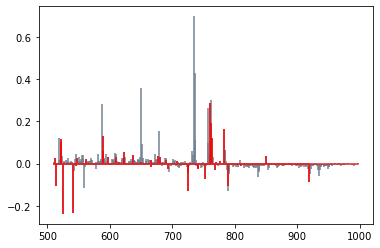

In [50]:
plt.stem(scmodel.intens_mtx.columns,
         scmodel.intens_mtx[scmodel.metadata['type']=='Neurons'].mean(0)-scmodel.intens_mtx[scmodel.metadata['type']=='Astrocytes'].mean(0),
        markerfmt=' ',linefmt='slategray')
plt.stem(scmodel.feature_retain[-5],
         scmodel.intens_mtx.loc[:,scmodel.feature_retain[-5]][scmodel.metadata['type']=='Neurons'].mean(0)-scmodel.intens_mtx.loc[:,scmodel.feature_retain[-5]][scmodel.metadata['type']=='Astrocytes'].mean(0),
        markerfmt=' ',linefmt='r')
plt.savefig('figures/selected_feat_icc.pdf')


In [290]:
sc_icc = scMSAnalysis(pd.DataFrame(df['type']))
sc_icc.preprocessing(scmodel.intens_mtx.loc[:,scmodel.feature_retain[-5]],norm_method='None',feat_drop_rate=0.005,cell_drop_rate=0.005)

filtered intensity matrix with shape (1543, 50)


In [291]:
sc_icc.get_labels(['type'])

In [292]:
sc_icc.analyze(n_neighbors=35, n_pcs=-1, min_dist=0.2, resolution = 0.7,
              categories=['type','leiden'])

computing neighbors..
performing umap...


The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'type' as categorical


performing clustering...


In [293]:
show_embed = widgets.interactive(sc_icc.show_cellEmbed, label=sc_icc.adata.obs.columns,
                                 embed_method=sc_icc.adata.obsm.keys(),size=(0.5,2,0.1));

In [294]:
show_embed

interactive(children=(Dropdown(description='label', options=('type', 'leiden'), value='type'), Dropdown(descri…

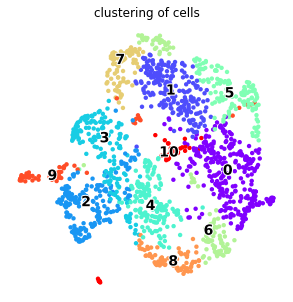

In [295]:
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(sc_icc.adata, color='leiden', add_outline=False, legend_loc='on data',
               legend_fontsize=14, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='rainbow')

In [296]:
import scanpy as sc

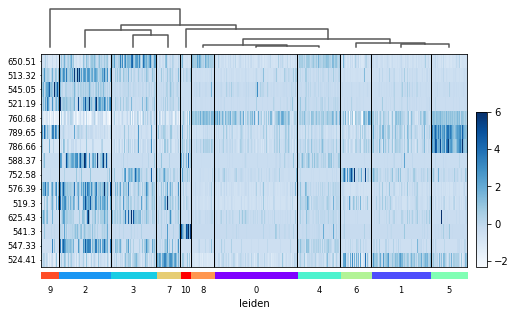

In [309]:
sc_icc.adata.layers['scaled'] = sc.pp.scale(sc_icc.adata, copy=True, zero_center=True).X
sc.pl.heatmap(sc_icc.adata,sc_icc.intens_mtx.columns[:15],groupby='leiden',layer='scaled',
              cmap='Blues',swap_axes=True,dendrogram=True,vmax=6,figsize=(8,5))

In [298]:
type_count = []
for i in sc_icc.metadata['leiden'].unique():
    cells = sc_icc.metadata[sc_icc.metadata['leiden']==i]['type']
    type_count.append(cells.value_counts()/cells.shape[0])

In [299]:
neuron_ratio = np.array([ratio.Neurons for ratio in type_count])
sort_idx = np.argsort(neuron_ratio)
neuron_ratio = neuron_ratio[sort_idx]
astro_ratio = 1-neuron_ratio

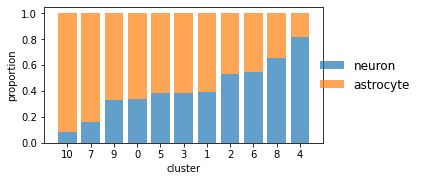

In [300]:
import matplotlib
fig,ax = plt.subplots(figsize=(5,2.5))
bottom = [0]*len(neuron_ratio)
# cmap = matplotlib.cm.get_cmap('rainbow')
# norm = matplotlib.colors.Normalize(vmin=0.0, vmax=4.0)

plt.bar(np.arange(0,len(neuron_ratio)),neuron_ratio, bottom=bottom,label='neuron',alpha=0.7)
bottom = [x + y for x, y in zip(bottom,neuron_ratio)]
plt.bar(np.arange(0,len(neuron_ratio)),astro_ratio, bottom=bottom,label='astrocyte'.format(i),alpha=0.7)

plt.legend()
plt.xlim([-1,11])
plt.ylabel('proportion')
plt.xlabel('cluster')
plt.xticks(ticks=np.arange(0,len(neuron_ratio)),labels=sc_icc.metadata['leiden'].unique()[sort_idx])
plt.legend(frameon=False,fontsize=12,ncol=1,loc='lower center',bbox_to_anchor=(1.15, .3))